In [3]:
pip install pandas matplotlib yfinance vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# Load the dataset
fed_data = pd.read_csv('communications.csv', parse_dates=['Release Date'])
print(fed_data.head())


         Date Release Date       Type  \
0  2024-12-18   2025-01-08     Minute   
1  2024-12-18   2024-12-18  Statement   
2  2024-11-07   2024-11-26     Minute   
3  2024-11-07   2024-11-07  Statement   
4  2024-09-18   2024-09-18  Statement   

                                                Text  
0  Minutes of the Federal Open Market Committee\n...  
1  Recent indicators suggest that economic activi...  
2  Minutes of the Federal Open Market Committee\n...  
3  Recent indicators suggest that economic activi...  
4  Recent indicators suggest that economic activi...  


In [72]:
import yfinance as yf

# Define indices
indices = {
    'DAX': '^GDAXI',  # Germany
    'CAC 40': '^FCHI',  # France
    'FTSE 100': '^FTSE'  # UK
}

# Fetch historical data
stock_data = {}
for name, ticker in indices.items():
    stock_data[name] = yf.download(ticker, start='2023-01-01', end='2023-12-31')

# Preview one of the datasets
print(stock_data['DAX'].head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open    Volume
Ticker            ^GDAXI        ^GDAXI        ^GDAXI        ^GDAXI    ^GDAXI
Date                                                                        
2023-01-02  14069.259766  14095.910156  13976.440430  13992.709961  34978500
2023-01-03  14181.669922  14293.870117  14083.759766  14116.070312  57907500
2023-01-04  14490.780273  14492.780273  14264.599609  14266.980469  76221600
2023-01-05  14436.309570  14501.599609  14403.730469  14451.230469  60947500
2023-01-06  14610.019531  14610.230469  14388.980469  14476.719727  55433700


In [73]:
keywords = ['interest rate', 'inflation', 'economic growth']

import re

def extract_relevant_phrases(text, keywords):
    if pd.isnull(text):  # Handle missing text values
        return []
    phrases = []
    for sentence in text.split('.'):  # Split into sentences
        if any(keyword in sentence.lower() for keyword in keywords):  # Check for keywords
            phrases.append(sentence.strip())  # Add relevant sentence
    return phrases


fed_data['Relevant Phrases'] = fed_data['Text'].apply(lambda x: extract_relevant_phrases(x, keywords))

print(fed_data[['Release Date', 'Relevant Phrases']].head())


  Release Date                                   Relevant Phrases
0   2025-01-08  [With near-term measures of inflation compensa...
1   2024-12-18  [Inflation has made progress toward the Commit...
2   2024-11-26  [The rise at short maturities reflected increa...
3   2024-11-07  [Inflation has made progress toward the Commit...
4   2024-09-18  [Inflation has made further progress toward th...


In [74]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


In [75]:
def calculate_sentiment(phrases):
    if not phrases:  # Handle empty lists
        return 0
    total_score = sum(analyzer.polarity_scores(phrase)['compound'] for phrase in phrases)
    return total_score / len(phrases)  # Average score


In [76]:
fed_data['Sentiment Score'] = fed_data['Relevant Phrases'].apply(calculate_sentiment)


In [77]:
print(fed_data[['Date', 'Sentiment Score']].head())


         Date  Sentiment Score
0  2024-12-18         0.156687
1  2024-12-18         0.072360
2  2024-11-07         0.153770
3  2024-11-07         0.072360
4  2024-09-18         0.208333


In [78]:
fed_data['Next Trading Day'] = pd.to_datetime(fed_data['Release Date']) + pd.DateOffset(1)


In [79]:
# Reset the index in both DataFrames to ensure consistency
fed_data = fed_data.reset_index(drop=True)
dax_data = dax_data.reset_index()


In [80]:
# Ensure 'Adjusted Trading Day' in fed_data and 'Date' in dax_data are datetime
fed_data['Adjusted Trading Day'] = pd.to_datetime(fed_data['Next Trading Day'])
dax_data['Date'] = pd.to_datetime(dax_data['Date'])


In [81]:
print(fed_data.columns)  # Check column names in fed_data
print(dax_data.columns)  # Check column names in dax_data


Index(['Date', 'Release Date', 'Type', 'Text', 'Relevant Phrases',
       'Sentiment Score', 'Next Trading Day', 'Adjusted Trading Day'],
      dtype='object')
Index(['index', 'Date', 'Close_^GDAXI', 'High_^GDAXI', 'Low_^GDAXI',
       'Open_^GDAXI', 'Volume_^GDAXI'],
      dtype='object')


In [82]:
print(fed_data.info())
print(dax_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  442 non-null    object        
 1   Release Date          413 non-null    datetime64[ns]
 2   Type                  442 non-null    object        
 3   Text                  442 non-null    object        
 4   Relevant Phrases      442 non-null    object        
 5   Sentiment Score       442 non-null    float64       
 6   Next Trading Day      413 non-null    datetime64[ns]
 7   Adjusted Trading Day  413 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(4)
memory usage: 27.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          1275 non-nu

In [83]:
# Flatten multi-level column names in dax_data
dax_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in dax_data.columns]

# Check the new column names
print(dax_data.columns)


Index(['index', 'Date', 'Close_^GDAXI', 'High_^GDAXI', 'Low_^GDAXI',
       'Open_^GDAXI', 'Volume_^GDAXI'],
      dtype='object')


In [84]:
print(fed_data.columns)  # Should include 'Adjusted Trading Day'
print(dax_data.columns)  # Should include 'Date'


Index(['Date', 'Release Date', 'Type', 'Text', 'Relevant Phrases',
       'Sentiment Score', 'Next Trading Day', 'Adjusted Trading Day'],
      dtype='object')
Index(['index', 'Date', 'Close_^GDAXI', 'High_^GDAXI', 'Low_^GDAXI',
       'Open_^GDAXI', 'Volume_^GDAXI'],
      dtype='object')


In [85]:
aligned_data = pd.merge(
    fed_data,
    dax_data,
    left_on='Adjusted Trading Day',  # From fed_data
    right_on='Date',                 # From dax_data
    how='inner'                      # Use inner join to keep only matching rows
)


In [86]:
print(aligned_data.columns)
print(aligned_data.head())


Index(['Date_x', 'Release Date', 'Type', 'Text', 'Relevant Phrases',
       'Sentiment Score', 'Next Trading Day', 'Adjusted Trading Day', 'index',
       'Date_y', 'Close_^GDAXI', 'High_^GDAXI', 'Low_^GDAXI', 'Open_^GDAXI',
       'Volume_^GDAXI'],
      dtype='object')
       Date_x Release Date       Type  \
0  2024-12-18   2024-12-18  Statement   
1  2024-11-07   2024-11-26     Minute   
2  2024-11-07   2024-11-07  Statement   
3  2024-09-18   2024-09-18  Statement   
4  2024-09-18   2024-10-09     Minute   

                                                Text  \
0  Recent indicators suggest that economic activi...   
1  Minutes of the Federal Open Market Committee\n...   
2  Recent indicators suggest that economic activi...   
3  Recent indicators suggest that economic activi...   
4  Minutes of the Federal Open Market Committee\n...   

                                    Relevant Phrases  Sentiment Score  \
0  [Inflation has made progress toward the Commit...         0.072360  

In [87]:
# Drop redundant columns
aligned_data = aligned_data.drop(columns=['Date_x', 'Date_y'])

# Verify the structure
print(aligned_data.columns)


Index(['Release Date', 'Type', 'Text', 'Relevant Phrases', 'Sentiment Score',
       'Next Trading Day', 'Adjusted Trading Day', 'index', 'Close_^GDAXI',
       'High_^GDAXI', 'Low_^GDAXI', 'Open_^GDAXI', 'Volume_^GDAXI'],
      dtype='object')


In [88]:
# Rename columns
aligned_data.rename(columns={
    'Adjusted Trading Day': 'Trading Day',
    'Close_^GDAXI': 'Close',
    'High_^GDAXI': 'High',
    'Low_^GDAXI': 'Low',
    'Open_^GDAXI': 'Open',
    'Volume_^GDAXI': 'Volume'
}, inplace=True)

# Verify the new column names
print(aligned_data.columns)


Index(['Release Date', 'Type', 'Text', 'Relevant Phrases', 'Sentiment Score',
       'Next Trading Day', 'Trading Day', 'index', 'Close', 'High', 'Low',
       'Open', 'Volume'],
      dtype='object')


In [89]:
aligned_data['Daily Change (%)'] = aligned_data['Close'].pct_change() * 100


In [90]:
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

aligned_data['Sentiment Category'] = aligned_data['Sentiment Score'].apply(categorize_sentiment)


In [91]:
print(aligned_data.head())


  Release Date       Type                                               Text  \
0   2024-12-18  Statement  Recent indicators suggest that economic activi...   
1   2024-11-26     Minute  Minutes of the Federal Open Market Committee\n...   
2   2024-11-07  Statement  Recent indicators suggest that economic activi...   
3   2024-09-18  Statement  Recent indicators suggest that economic activi...   
4   2024-10-09     Minute  Minutes of the Federal Open Market Committee\n...   

                                    Relevant Phrases  Sentiment Score  \
0  [Inflation has made progress toward the Commit...         0.072360   
1  [The rise at short maturities reflected increa...         0.153770   
2  [Inflation has made progress toward the Commit...         0.072360   
3  [Inflation has made further progress toward th...         0.208333   
4  [The decline in nominal yields over the period...         0.193364   

  Next Trading Day Trading Day  index         Close          High  \
0       202

In [92]:
correlation = aligned_data[['Sentiment Score', 'Daily Change (%)']].corr()
print("Correlation Matrix:\n", correlation)


Correlation Matrix:
                   Sentiment Score  Daily Change (%)
Sentiment Score          1.000000          0.063152
Daily Change (%)         0.063152          1.000000


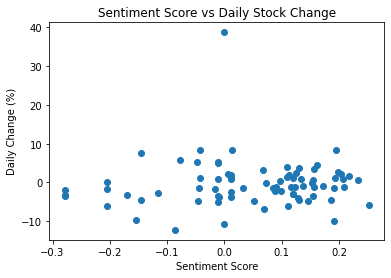

In [93]:
import matplotlib.pyplot as plt

plt.scatter(aligned_data['Sentiment Score'], aligned_data['Daily Change (%)'])
plt.title('Sentiment Score vs Daily Stock Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Change (%)')
plt.show()


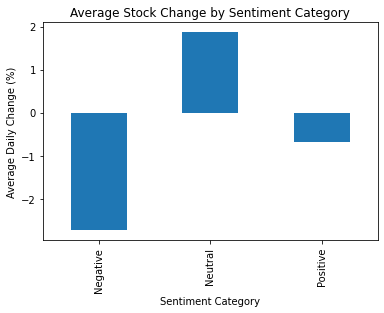

In [94]:
sentiment_group = aligned_data.groupby('Sentiment Category')['Daily Change (%)'].mean()
sentiment_group.plot(kind='bar', title='Average Stock Change by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Daily Change (%)')
plt.show()


In [95]:
print(aligned_data.isnull().sum())


Release Date          0
Type                  0
Text                  0
Relevant Phrases      0
Sentiment Score       0
Next Trading Day      0
Trading Day           0
index                 0
Close                 0
High                  0
Low                   0
Open                  0
Volume                0
Daily Change (%)      1
Sentiment Category    0
dtype: int64


In [96]:
aligned_data['Daily Change (%)'].fillna(0, inplace=True)


In [97]:
# Verify that the required columns exist
required_columns = ['Sentiment Score', 'Daily Change (%)', 'Sentiment Category']

for col in required_columns:
    assert col in aligned_data.columns, f"Column '{col}' is missing in aligned_data!"


In [98]:
# Check data types of key columns
print(aligned_data[['Sentiment Score', 'Daily Change (%)', 'Sentiment Category']].dtypes)


Sentiment Score       float64
Daily Change (%)      float64
Sentiment Category     object
dtype: object


In [99]:
aligned_data['Sentiment Category'] = aligned_data['Sentiment Category'].astype('category')


In [100]:
print(aligned_data[['Sentiment Category']].dtypes)


Sentiment Category    category
dtype: object


In [101]:
print(aligned_data[['Sentiment Score', 'Daily Change (%)']].describe())


       Sentiment Score  Daily Change (%)
count        80.000000         80.000000
mean          0.047567         -0.308184
std           0.128904          6.080630
min          -0.279040        -12.234089
25%          -0.010986         -3.436813
50%           0.078373         -1.099644
75%           0.139390          1.725308
max           0.252171         38.725047


In [102]:
print(aligned_data['Sentiment Category'].value_counts())


Positive    45
Neutral     22
Negative    13
Name: Sentiment Category, dtype: int64


In [103]:
correlation = aligned_data[['Sentiment Score', 'Daily Change (%)']].corr()
print("Correlation Matrix:\n", correlation)


Correlation Matrix:
                   Sentiment Score  Daily Change (%)
Sentiment Score          1.000000          0.063261
Daily Change (%)         0.063261          1.000000


In [104]:
sentiment_group = aligned_data.groupby('Sentiment Category')['Daily Change (%)'].mean()
print(sentiment_group)


Sentiment Category
Negative   -2.722745
Neutral     1.866763
Positive   -0.673952
Name: Daily Change (%), dtype: float64


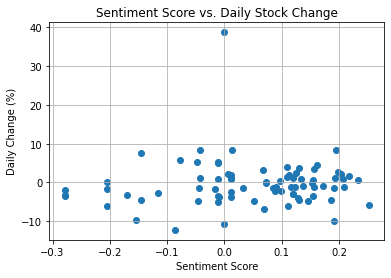

In [105]:
import matplotlib.pyplot as plt

plt.scatter(aligned_data['Sentiment Score'], aligned_data['Daily Change (%)'])
plt.title('Sentiment Score vs. Daily Stock Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Change (%)')
plt.grid(True)
plt.show()


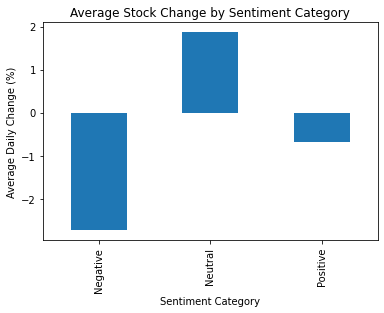

In [106]:
sentiment_group.plot(kind='bar', title='Average Stock Change by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Daily Change (%)')
plt.show()


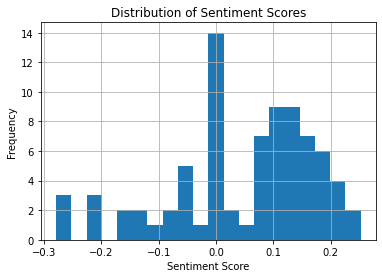

In [107]:
aligned_data['Sentiment Score'].hist(bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [3]:
import numpy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [4]:
# Define the features (sentiment score) and target variable (stock price change)
X = merged_data[['Sentiment Score']]  # Sentiment score as the independent variable
y = merged_data['Average Daily Change (%)']  # Daily percentage change in stock prices as the dependent variable


NameError: name 'merged_data' is not defined

In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model using the data
model.fit(X, y)


In [ ]:
# Predict the stock price changes using the trained model
predictions = model.predict(X)


In [ ]:
# Calculate the R-squared value (Goodness of fit)
r2 = r2_score(y, predictions)

# Calculate the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y, predictions, squared=False)

# Print the evaluation metrics
print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,6))

# Scatter plot of actual values
plt.scatter(y, predictions, color='blue', alpha=0.6)

# Line of perfect prediction (y = x)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')

# Labels and title
plt.title('Actual vs. Predicted Stock Price Changes', fontsize=16)
plt.xlabel('Actual Stock Price Change (%)', fontsize=14)
plt.ylabel('Predicted Stock Price Change (%)', fontsize=14)

# Show the plot
plt.show()
